In [1]:
import os
import time
import torch
import timm
import joblib
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from torchvision import transforms, datasets
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, top_k_accuracy_score
import matplotlib.pyplot as plt
import cv2
from skimage.filters import gabor
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.morphology import opening, closing, dilation, erosion, disk
from sklearn.preprocessing import StandardScaler
from time import perf_counter
from torch.serialization import add_safe_globals

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


In [2]:
BASE = "/workspace/Notebooks/"

MODELS = {
    "tiny-vit": {
        "label":"TinyViT 21M",
        "arch":"tiny_vit_21m_224",
        "path": os.path.join(BASE, "Tiny-ViT", "best_tinyvit_full.pth"),
        "timm": True
    },
    "resnet-rs": {
        "label":"ResNet-RS50",
        "arch":"resnetrs50",
        "path": os.path.join(BASE, "ResNet-RS", "best_ResNet-RS_full.pth"),
        "timm": True
    },
    "swin": {
        "label":"Swin Small",
        "arch":"swin_small_patch4_window7_224",
        "path": os.path.join(BASE, "SWIN", "best_SWIN_full.pth"),
        "timm": True
    },
    "efficientnetv2": {
        "label":"EfficientNetV2-RW-S",
        "arch":"efficientnetv2_rw_s",
        "path": os.path.join(BASE, "EfficientNetV2-RW-S", "best_EfficientNetV2-RW-S_full.pth"),
        "timm": True
    },
    "deit3": {
        "label":"DEiT III",
        "arch":"deit3_base_patch16_224",
        "path": os.path.join(BASE, "DEiT-III", "best_DEiT III_full.pth"),
        "timm": True
    },
    "convnext": {
        "label":"ConvNeXt-Small",
        "arch":"convnext_small.in12k_ft_in1k",
        "path": os.path.join(BASE, "ConvNeXt-Small", "best_ConvNeXt-Small_full.pth"),
        "timm": True
    },
    "simplecnn": {
        "label":"CNN Basica",
        "arch":"simple_cnn",
        "path": os.path.join(BASE, "CNN-Basica", "cnn_basica_model.pth"),
        "timm": False
    },
}
# muestra rutas
for k,v in MODELS.items():
    print(k, "->", v["path"], "exists:", os.path.exists(v["path"]))

tiny-vit -> /workspace/Notebooks/Tiny-ViT/best_tinyvit_full.pth exists: True
resnet-rs -> /workspace/Notebooks/ResNet-RS/best_ResNet-RS_full.pth exists: True
swin -> /workspace/Notebooks/SWIN/best_SWIN_full.pth exists: True
efficientnetv2 -> /workspace/Notebooks/EfficientNetV2-RW-S/best_EfficientNetV2-RW-S_full.pth exists: True
deit3 -> /workspace/Notebooks/DEiT-III/best_DEiT III_full.pth exists: True
convnext -> /workspace/Notebooks/ConvNeXt-Small/best_ConvNeXt-Small_full.pth exists: True
simplecnn -> /workspace/Notebooks/CNN-Basica/cnn_basica_model.pth exists: True


In [3]:
# Dataset paths y loaders
DATASET_PATH = "/workspace/Data/arcDataset_split"
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 25

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

from torch.utils.data import DataLoader
if os.path.exists(DATASET_PATH):
    train_ds = datasets.ImageFolder(os.path.join(DATASET_PATH, "train"), transform=train_tf)
    val_ds = datasets.ImageFolder(os.path.join(DATASET_PATH, "val"), transform=val_tf)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    print("Dataset classes:", len(val_ds.classes))

Dataset classes: 25


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def load_torch_model_from_full(path, arch=None):
    """Intenta torch.load un objeto guardado (modelo completo). Si falla, intenta crear arquitectura timm y cargar state_dict"""
    if not os.path.exists(path):
        print("No existe archivo:", path)
        return None
    try:
        m = torch.load(path, map_location=DEVICE)
        # si se guardó con torch.save(model) -> devuelve nn.Module
        if isinstance(m, nn.Module):
            m.to(DEVICE)
            m.eval()
            return m
        if isinstance(m, dict) and 'model_state_dict' in m:
            if arch and arch.startswith("convnext") is False and arch != "simple_cnn":
                try:
                    model = timm.create_model(arch, pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
                except Exception:
                    model = timm.create_model(arch, pretrained=True, num_classes=NUM_CLASSES).to(DEVICE)
            elif arch == "simple_cnn":
                model = SimpleCNN().to(DEVICE)
            else:
                model = timm.create_model(arch, pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
            model.load_state_dict(m['model_state_dict'])
            model.eval()
            return model
        # si es state_dict
        if isinstance(m, dict) and any(k.startswith('epoch') or k.startswith('model_state_dict') for k in m.keys()):
            # handled above
            pass
        # fallback: try load as model object
        return m
    except Exception as e:
        print("Error cargando con torch.load:", e)
        # fallback: si es timm arch disponiblre, crea modelo e intenta load_state_dict
        if arch and arch != "simple_cnn":
            try:
                model = timm.create_model(arch, pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
                state = torch.load(path, map_location=DEVICE)
                if isinstance(state, dict) and 'model_state_dict' in state:
                    model.load_state_dict(state['model_state_dict'])
                elif isinstance(state, dict):
                    model.load_state_dict(state)
                model.eval()
                return model
            except Exception as e2:
                print("Fallo fallback timm:", e2)
    return None

In [5]:
# Cargar modelos y preparar función de predict/inferencia
loaded_models = {}
rf_scaler = None
rf_model = None

for key, meta in MODELS.items():
    p = meta["path"]
    if not os.path.exists(p):
        print(f"[SKIP] {key} -> archivo no encontrado: {p}")
        continue
        
    # MODELOS TORCH (TIMM)
    if meta["timm"]:
        try:
            model = load_torch_model_from_full(p, arch=meta["arch"])

            # fallback: crear modelo timm y cargar state_dict
            if model is None:
                model = timm.create_model(
                    meta["arch"], pretrained=True, num_classes=NUM_CLASSES
                ).to(DEVICE)

                try:
                    state = torch.load(p, map_state_dict=False,
                                       map_location=DEVICE,
                                       weights_only=True)

                    # formatos aceptados
                    if isinstance(state, dict) and "model_state_dict" in state:
                        model.load_state_dict(state["model_state_dict"])
                    elif isinstance(state, dict):
                        model.load_state_dict(state)

                except Exception as e2:
                    print("Fallo fallback timm:", e2)

            model.eval()
            loaded_models[key] = model
            print(f"Cargado {key} -> {meta['label']}")

        except Exception as e:
            print(f"Fallo cargando {key}:", e)

    # SIMPLE CNN
    else:
        try:
            # SIEMPRE crear el modelo manual
            model = SimpleCNN().to(DEVICE)
    
            # cargar el archivo .pth
            state = torch.load(p, map_location=DEVICE, weights_only=False)
    
            # si viene dict con "model_state_dict"
            if isinstance(state, dict) and "model_state_dict" in state:
                model.load_state_dict(state["model_state_dict"])
    
            # si viene state_dict puro (OrderedDict)
            elif isinstance(state, dict):
                model.load_state_dict(state)
    
            else:
                print("Formato inesperado para SimpleCNN:", type(state))
    
            model.eval()
            loaded_models[key] = model
            print("Cargado simplecnn")
    
        except Exception as e:
            print("Error cargando simplecnn:", e)

# --------------------------------
# PREDICT HELPERS
# --------------------------------
def predict_torch_model(model, pil_img, topk=3):
    model.eval()
    x = val_tf(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    topk_idx = probs.argsort()[-topk:][::-1]
    return [(int(i), float(probs[i])) for i in topk_idx]

/tmp/ipykernel_10740/4198955966.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load(path, map_location=DEVICE)


Cargado tiny-vit -> TinyViT 21M
Cargado resnet-rs -> ResNet-RS50
Cargado swin -> Swin Small
Cargado efficientnetv2 -> EfficientNetV2-RW-S
Cargado deit3 -> DEiT III
Cargado convnext -> ConvNeXt-Small
Cargado simplecnn


In [6]:
# Evaluación y benchmark
results = []
if val_loader is None:
    print("Val loader no disponible. Ajusta DATASET_PATH para evaluar en val set.")
else:
    for key, model in loaded_models.items():
        print("\nEvaluando:", key)
        # params count (si es torch.nn)
        try:
            params = sum(p.numel() for p in model.parameters())
        except Exception:
            params = None
        # size on disk
        size_bytes = None
        if os.path.exists(MODELS[key]["path"]):
            size_bytes = os.path.getsize(MODELS[key]["path"])
        # inference timing (averaged)
        n_samples = 0
        all_preds = []
        all_labels = []
        t0 = perf_counter()
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(DEVICE)
                logits = model(x)
                preds = logits.argmax(dim=1).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(y.numpy())
                n_samples += x.shape[0]
        t1 = perf_counter()
        if n_samples==0:
            avg_inf_ms = None
        else:
            avg_inf_ms = (t1 - t0)/n_samples*1000
        if len(all_preds)>0:
            y_pred = np.concatenate(all_preds)
            y_true = np.concatenate(all_labels)
            acc1 = accuracy_score(y_true, y_pred)
            try:
                # for top-5 need logits; recompute in batches to collect logits
                all_logits = []
                with torch.no_grad():
                    for x,y in val_loader:
                        x = x.to(DEVICE)
                        logits = model(x)
                        all_logits.append(logits.cpu().numpy())
                all_logits = np.concatenate(all_logits)
                top5 = top_k_accuracy_score(y_true, all_logits, k=5)
            except Exception:
                top5 = None
            # confusion and report
            cm = confusion_matrix(y_true, y_pred)
            creport = classification_report(y_true, y_pred, output_dict=True)
        else:
            acc1 = None
            top5 = None
            cm = None
            creport = None

        results.append({
            "model_key": key,
            "label": MODELS[key]["label"],
            "params": params,
            "size_bytes": size_bytes,
            "avg_inf_ms": avg_inf_ms,
            "top1": acc1,
            "top5": top5,
            "confusion": cm,
            "class_report": creport
        })
        print(f"{key}: top1={acc1} top5={top5} avg_inf_ms={avg_inf_ms} params={params} size_bytes={size_bytes}")


Evaluando: tiny-vit
tiny-vit: top1=0.8864809081527347 top5=0.9803921568627451 avg_inf_ms=4.179246605777994 params=20635993 size_bytes=96222906

Evaluando: resnet-rs
resnet-rs: top1=0.8544891640866873 top5=0.9731682146542827 avg_inf_ms=3.8993880980389437 params=33694137 size_bytes=135192918

Evaluando: swin
swin: top1=0.8658410732714138 top5=0.9721362229102167 avg_inf_ms=5.09314898555195 params=48856483 size_bytes=197219818

Evaluando: efficientnetv2
efficientnetv2: top1=0.848297213622291 top5=0.9731682146542827 avg_inf_ms=3.80058675954687 params=22193121 size_bytes=89837970

Evaluando: deit3
deit3: top1=0.8338493292053664 top5=0.9587203302373581 avg_inf_ms=6.229425041278393 params=85835545 size_bytes=343460110

Evaluando: convnext
convnext: top1=0.8751289989680082 top5=0.9752321981424149 avg_inf_ms=4.341154368421063 params=49473913 size_bytes=198111006

Evaluando: simplecnn
simplecnn: top1=0.37770897832817335 top5=0.7430340557275542 avg_inf_ms=3.26689959442807 params=51486809 size_byt

In [7]:
import pandas as pd
import numpy as np
import os

OUT_DIR = "/workspace/Notebooks"
TRAIN_CSV = os.path.join(OUT_DIR, "training_results.csv")

# ---- Cargar CSV ----
if os.path.exists(TRAIN_CSV):
    train_df = pd.read_csv(TRAIN_CSV)
    train_df["model"] = train_df["model"].astype(str)
else:
    train_df = None

for r in results:
    r["train_name"] = r["label"]

# ---- Construcción base ----
rows = []
for r in results:
    rows.append({
        "Model": r["label"],
        "Params": r["params"],
        "Model Size (MB)": round(r["size_bytes"]/1024/1024,2) if r.get("size_bytes") else None,
        "Avg inf (ms/img)": round(r["avg_inf_ms"],3) if r.get("avg_inf_ms") else None,
        "Top-1 val": round(r["top1"],4) if r.get("top1") else None,
        "Top-5 val": round(r["top5"],4) if r.get("top5") else None,
    })
df = pd.DataFrame(rows)

macro_f1_dict = {}
for r in results:
    crep = r.get("class_report")
    macro_f1 = crep["macro avg"]["f1-score"] if crep and "macro avg" in crep else None
    macro_f1_dict[r["label"]] = macro_f1

df["MacroF1"] = df["Model"].map(macro_f1_dict)

# ---- Añadir columnas del CSV ----
if train_df is not None:

    # Tiempo total
    train_time = train_df.groupby("model")["total_time_min"].first().rename("Train Time (min)")

    # Early stopping
    early_stop = train_df.groupby("model")["early_stopped"].max().rename("Early Stop")

    # Total epochs
    total_epochs = train_df.groupby("model")["epoch"].max().rename("Total Epochs")

    # Best val metrics
    best_vals = train_df.loc[train_df.groupby("model")["val_acc"].idxmax(), ["model","epoch","val_acc","val_loss"]]
    best_vals = best_vals.set_index("model").rename(columns={
        "epoch":"Best Epoch",
        "val_acc":"Best Val Acc",
        "val_loss":"Best Val Loss"
    })
    
    df = df.merge(train_time,    how="left", left_on="Model", right_index=True)
    df = df.merge(early_stop,    how="left", left_on="Model", right_index=True)
    df = df.merge(total_epochs,  how="left", left_on="Model", right_index=True)
    df = df.merge(best_vals,     how="left", left_on="Model", right_index=True)

df_sorted = df.sort_values("Top-1 val", ascending=False).reset_index(drop=True)
df_sorted

,Model,Params,Model Size (MB),Avg inf (ms/img),Top-1 val,Top-5 val,MacroF1,Train Time (min),Early Stop,Total Epochs,Best Epoch,Best Val Acc,Best Val Loss
0,TinyViT 21M,20635993,91.77,4.179,0.8865,0.9804,0.868986,16.49,0,50,43,0.8865,0.7594
1,ConvNeXt-Small,49473913,188.93,4.341,0.8751,0.9752,0.858020,20.66,0,50,43,0.8751,0.8269
2,Swin Small,48856483,188.08,5.093,0.8658,0.9721,0.841432,43.89,1,27,20,0.8658,0.8668
3,ResNet-RS50,33694137,128.93,3.899,0.8545,0.9732,0.831966,12.38,1,39,32,0.8545,0.8184
4,EfficientNetV2-RW-S,22193121,85.68,3.801,0.8483,0.9732,0.827172,14.75,1,47,40,0.8483,0.8650
5,DEiT III,85835545,327.55,6.229,0.8338,0.9587,0.806798,9.34,1,19,12,0.8338,0.9275
6,CNN Basica,51486809,196.41,3.267,0.3777,0.7430,0.300571,7.80,0,30,22,0.3932,3.5148


In [41]:
# Métricas por modelo
metric_rows = []

for r in results:
    crep = r.get("class_report")     # dict sklearn
    macro_f1 = None

    if crep is not None and "macro avg" in crep:
        macro_f1 = crep["macro avg"]["f1-score"]

    metric_rows.append({
        "Key": r["model_key"],
        "Label": r["label"],
        "Top1": r["top1"],
        "Top5": r["top5"],
        "MacroF1": macro_f1,
    })

metrics_df = pd.DataFrame(metric_rows)
metrics_df_sorted = metrics_df.sort_values("Top1", ascending=False).reset_index(drop=True)
metrics_df_sorted

,Key,Label,Top1,Top5,MacroF1
0,tiny-vit,TinyViT 21M,0.886481,0.980392,0.868986
1,convnext,ConvNeXt-Small,0.875129,0.975232,0.858020
2,swin,Swin Small,0.865841,0.972136,0.841432
3,resnet-rs,ResNet-RS50,0.854489,0.973168,0.831966
4,efficientnetv2,EfficientNetV2-RW-S,0.848297,0.973168,0.827172
5,deit3,DEiT III,0.833849,0.958720,0.806798
6,simplecnn,CNN Basica,0.377709,0.743034,0.300571


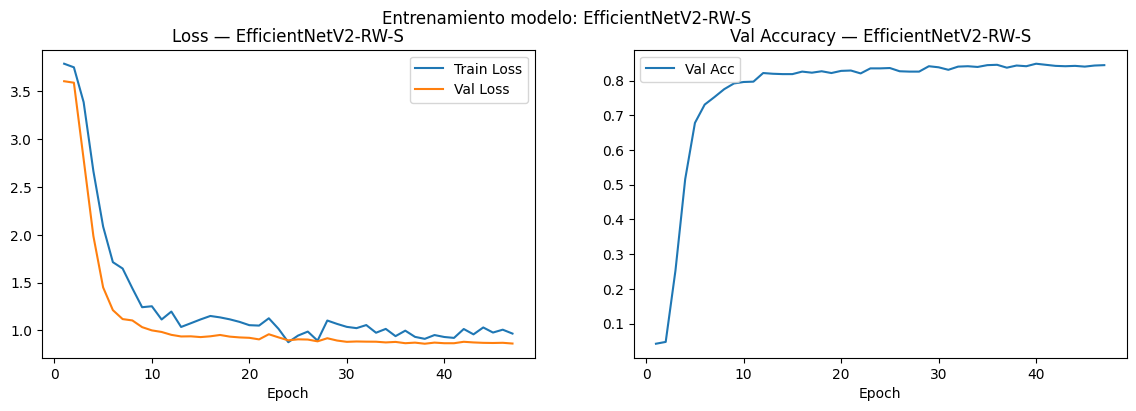

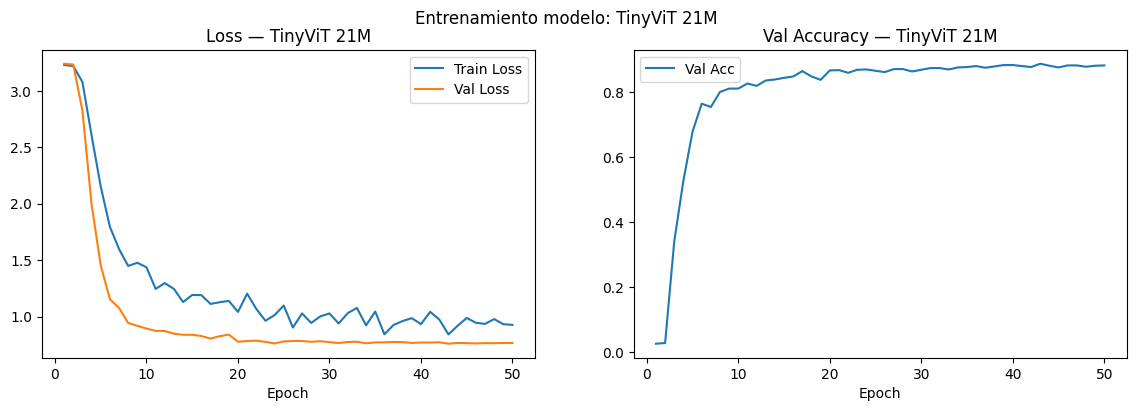

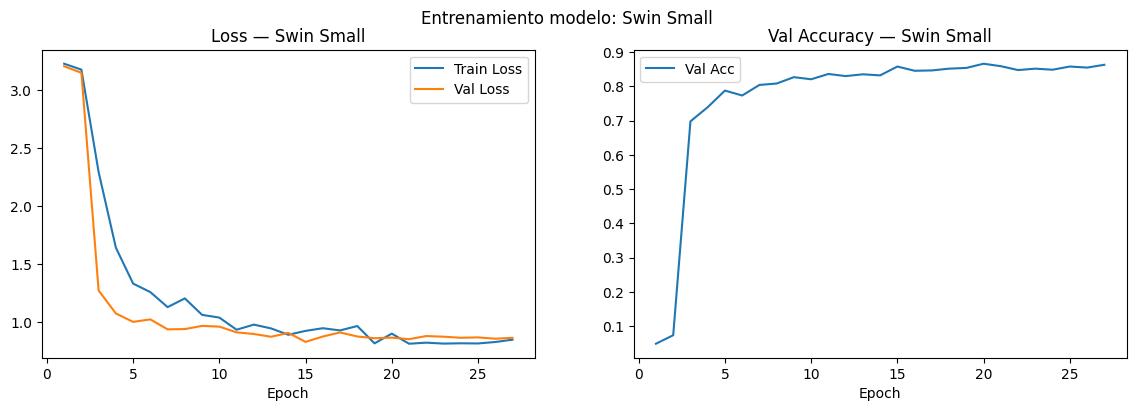

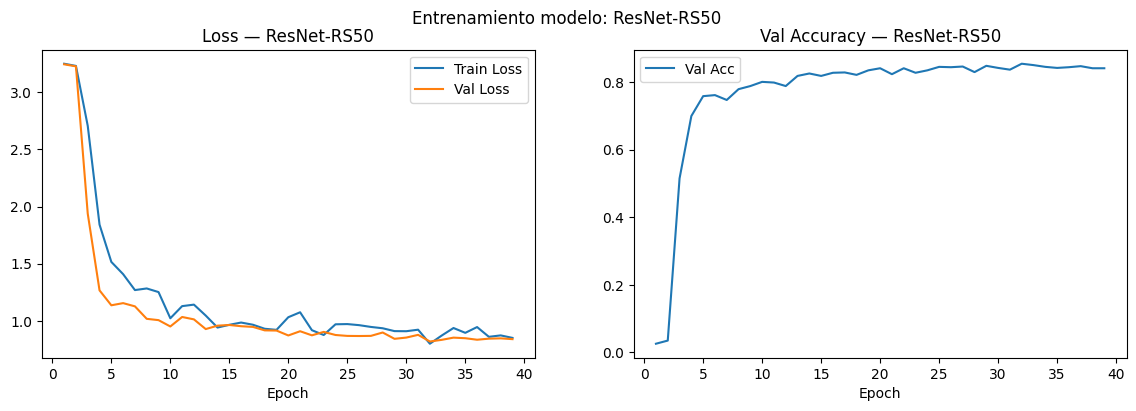

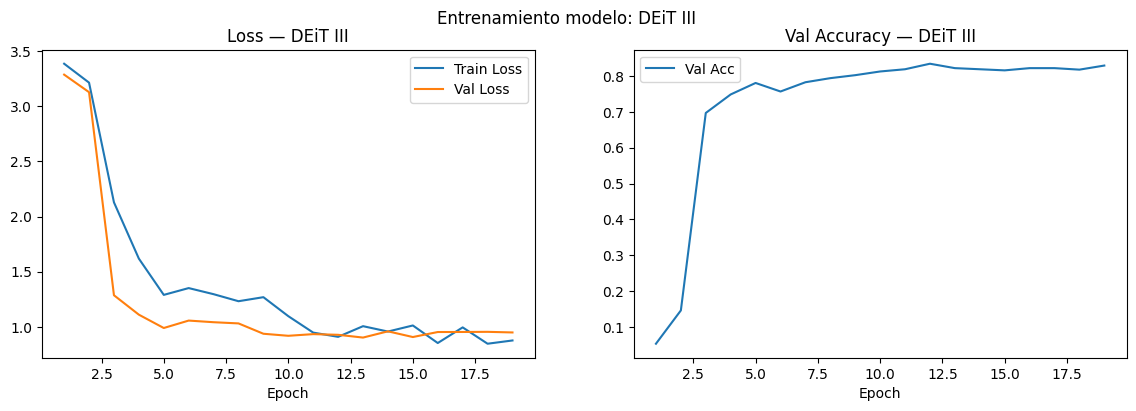

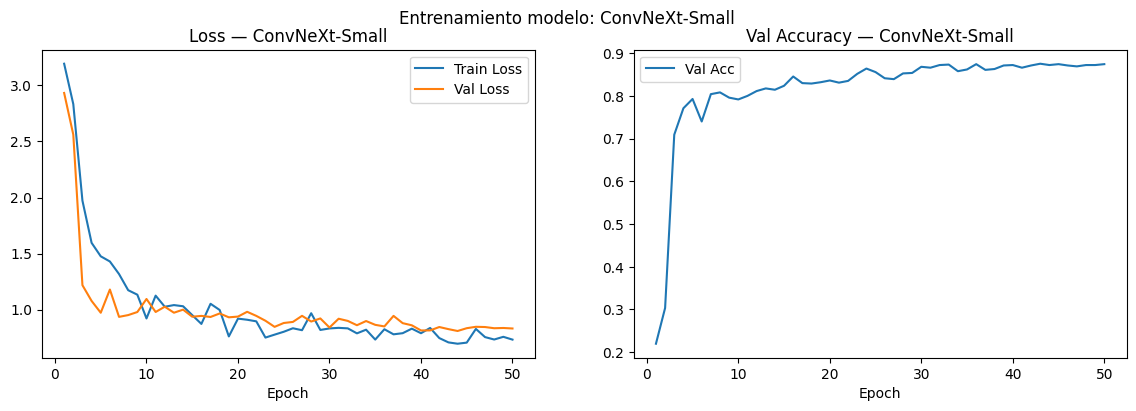

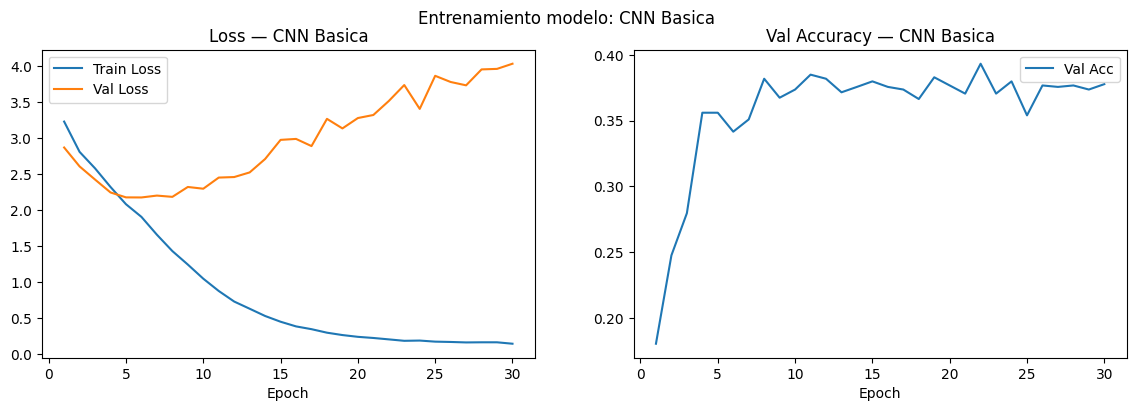

In [12]:
# Gráficas individuales por modelo
import matplotlib.pyplot as plt

if train_df is None:
    print("training_results.csv no existe")
else:
    models = train_df["model"].unique()
    for m in models:
        sub = train_df[train_df["model"] == m].sort_values("epoch")

        plt.figure(figsize=(14,4))

        # LOSS
        plt.subplot(1,2,1)
        plt.plot(sub["epoch"], sub["train_loss"], label="Train Loss")
        plt.plot(sub["epoch"], sub["val_loss"], label="Val Loss")
        plt.title(f"Loss — {m}")
        plt.xlabel("Epoch")
        plt.legend()

        # VAL ACC
        plt.subplot(1,2,2)
        plt.plot(sub["epoch"], sub["val_acc"], label="Val Acc")
        plt.title(f"Val Accuracy — {m}")
        plt.xlabel("Epoch")
        plt.legend()

        plt.suptitle(f"Entrenamiento modelo: {m}")
        plt.show()

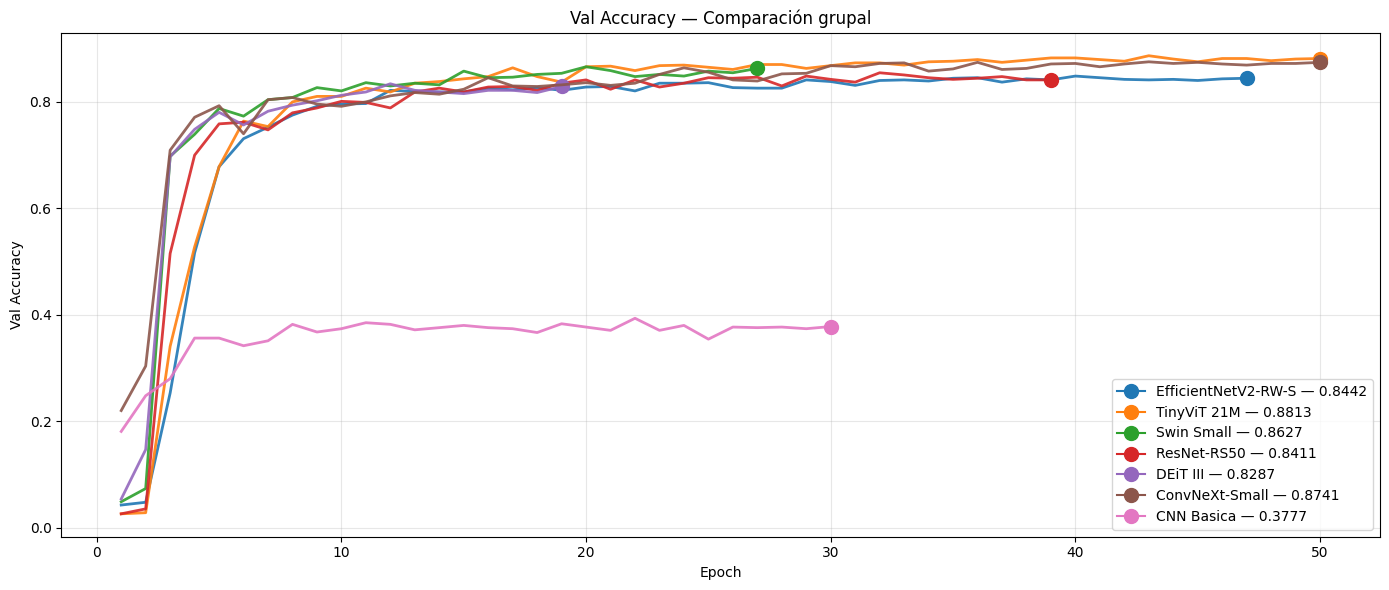

In [48]:
# Val Accuracy grupal
plt.figure(figsize=(14,6))
models = train_df["model"].unique()

for m in models:
    sub = train_df[train_df["model"] == m].sort_values("epoch")
    epochs = sub["epoch"].values
    vals   = sub["val_acc"].values
    final_val   = vals[-1]
    final_epoch = epochs[-1]
    line, = plt.plot(epochs, vals, linewidth=2, alpha=0.9)
    color = line.get_color()
    plt.plot(final_epoch, final_val, marker='o', markersize=10,
                color=color,
                label=f"{m} — {final_val:.4f}")
    
plt.title("Val Accuracy — Comparación grupal")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

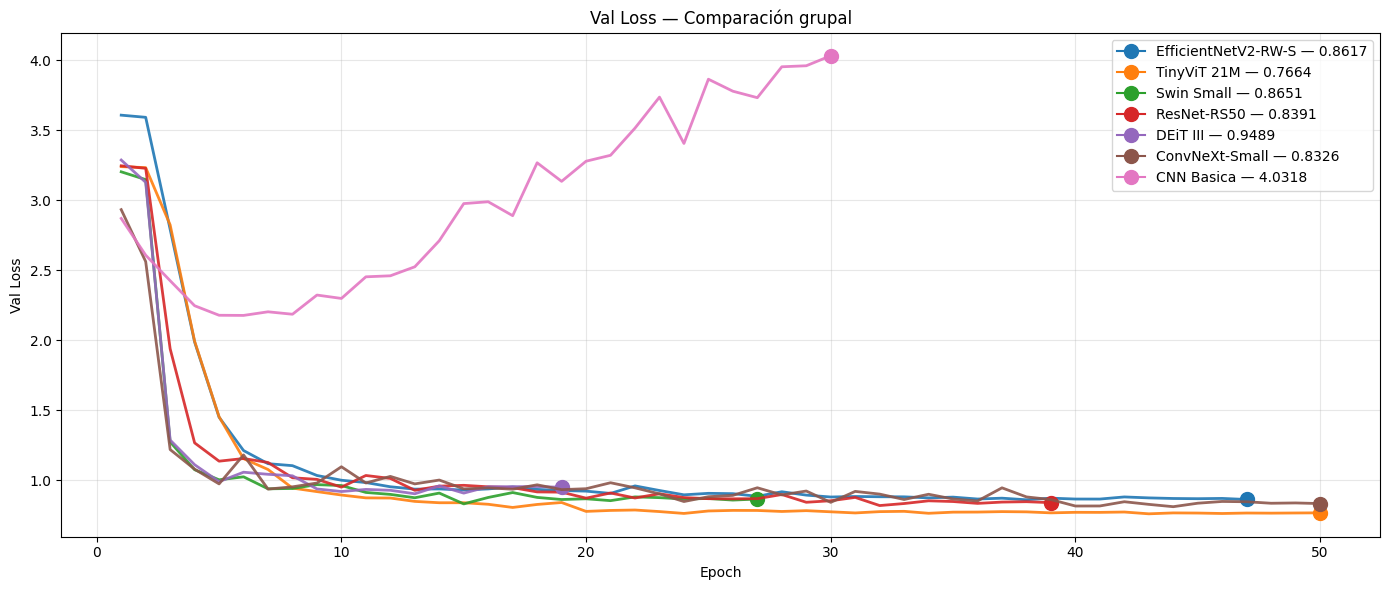

In [47]:
# Val Loss grupal
plt.figure(figsize=(14,6))
models = train_df["model"].unique()

for m in models:
    sub = train_df[train_df["model"] == m].sort_values("epoch")
    epochs = sub["epoch"].values
    vals   = sub["val_loss"].values
    final_val   = vals[-1]
    final_epoch = epochs[-1]
    line, = plt.plot(epochs, vals, linewidth=2, alpha=0.9)
    color = line.get_color()
    plt.plot(final_epoch, final_val, marker='o', markersize=10,
             color=color,
             label=f"{m} — {final_val:.4f}")

plt.title("Val Loss — Comparación grupal")
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
# Selección del mejor modelo
best_top1 = metrics_df.loc[metrics_df["Top1"].idxmax()]
best_macrof1 = metrics_df.loc[metrics_df["MacroF1"].idxmax()]

print("Mejor modelo según Top-1")
display(best_top1)

print("\nMejor modelo según Macro F1")
display(best_macrof1)

Mejor modelo según Top-1


Key           tiny-vit
Label      TinyViT 21M
Top1          0.886481
Top5          0.980392
MacroF1       0.868986
Name: 0, dtype: object


Mejor modelo según Macro F1


Key           tiny-vit
Label      TinyViT 21M
Top1          0.886481
Top5          0.980392
MacroF1       0.868986
Name: 0, dtype: object

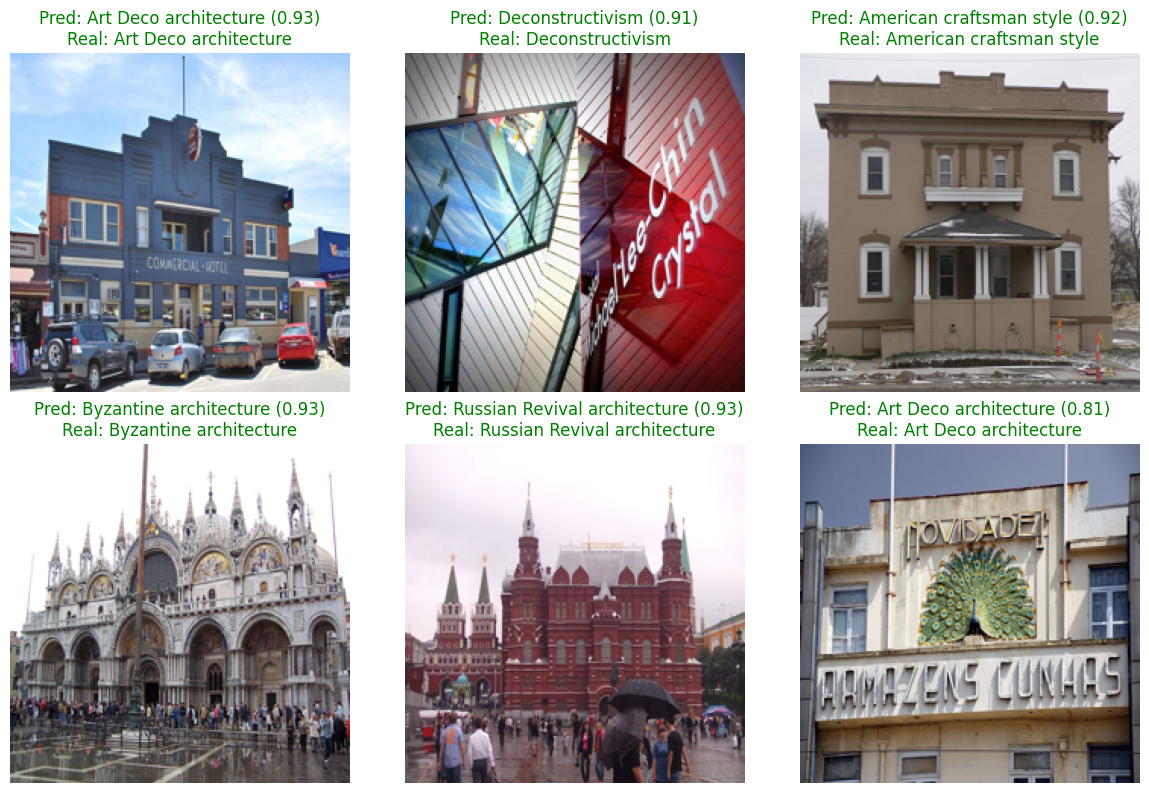

In [25]:
# Mostrar predicciones sample
def show_predictions_for_model(model_key, num_images=6):
    if val_ds is None:
        print("val_ds no disponible")
        return
    if model_key != "randomforest" and model_key not in loaded_models:
        print("Modelo torch no cargado:", model_key)
        return

    plt.figure(figsize=(12,8))
    for i in range(num_images):
        idx = random.randint(0, len(val_ds)-1)
        img_path, label = val_ds.imgs[idx]
        pil = Image.open(img_path).convert("RGB").resize((IMG_SIZE,IMG_SIZE))
        if model_key == "randomforest":
            preds = predict_rf(img_path, topk=1)
            pred_idx, prob = preds[0]
        else:
            preds = predict_torch_model(loaded_models[model_key], pil, topk=1)
            pred_idx, prob = preds[0]
        plt.subplot(2,3,i+1)
        plt.imshow(pil)
        plt.title(f"Pred: {val_ds.classes[pred_idx]} ({prob:.2f})\nReal: {val_ds.classes[label]}", color=("green" if pred_idx==label else "red"))
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
show_predictions_for_model("tiny-vit", num_images=6)